In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tqdm import tqdm

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

def extract_landmarks(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)
    
    # if results.multi_hand_landmarks:
    #     hand_landmarks = results.multi_hand_landmarks[0]
    #     landmarks = []
    #     for lm in hand_landmarks.landmark:
    #         landmarks.extend([lm.x, lm.y, lm.z])
    #     return np.array(landmarks)
    # return None

    landmarks = []
    if results.multi_hand_landmarks:
        # Process up to 2 hands
        for hand_landmarks in results.multi_hand_landmarks[:2]:
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
        # Pad with zeros if only one hand detected
        if len(results.multi_hand_landmarks) == 1:
            landmarks += [0.0] * 63  # 21 landmarks * 3 values
    return np.array(landmarks) if len(landmarks) > 0 else None

# Process dataset
dataset_path = "Datasets/ISL characters/Indian"
classes = sorted(os.listdir(dataset_path))
X = []
y = []

for class_name in tqdm(classes):
    class_dir = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        landmarks = extract_landmarks(img_path)
        if landmarks is not None:
            X.append(landmarks)
            y.append(class_name)

# Save processed data
np.save("X.npy", X)
np.save("y.npy", y)
print("Dataset processing complete!")

100%|██████████████████████████████████████| 35/35 [30:52<00:00, 52.94s/it]

Dataset processing complete!


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Load processed data
X = np.load("X.npy")
y = np.load("y.npy")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
np.save("classes.npy", le.classes_)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Build model
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(63,)),
#     Dropout(0.5),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(35, activation='softmax')
# ])

# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

def create_model(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(35, activation='softmax')
    ])
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

# Update input shape to 126 (2 hands * 21 landmarks * 3 coordinates)
model = create_model((126,))

# Train model
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    batch_size=32)

# Save model
model.save("isl_model.h5")
print("Model training complete!")

Epoch 1/50


C:\Users\shiva\OneDrive\Documents\GitHub\ISL\ISL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1043/1043 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7288 - loss: 1.0426 - val_accuracy: 0.9892 - val_loss: 0.0375
Epoch 2/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9606 - loss: 0.1249 - val_accuracy: 0.9947 - val_loss: 0.0208
Epoch 3/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9705 - loss: 0.0949 - val_accuracy: 0.9717 - val_loss: 0.0570
Epoch 4/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9678 - loss: 0.0994 - val_accuracy: 0.9898 - val_loss: 0.0251
Epoch 5/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9725 - loss: 0.0841 - val_accuracy: 0.9916 - val_loss: 0.0225
Epoch 6/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9760 - loss: 0.0800 - val_accuracy: 0.9982 - val_loss: 0.0077
Epoch 7/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9776 - loss: 0.0729 - val_accuracy: 0.9950 - val_loss: 0.0130
Epoch 8/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9788 - loss: 0.0673 - val_accurac

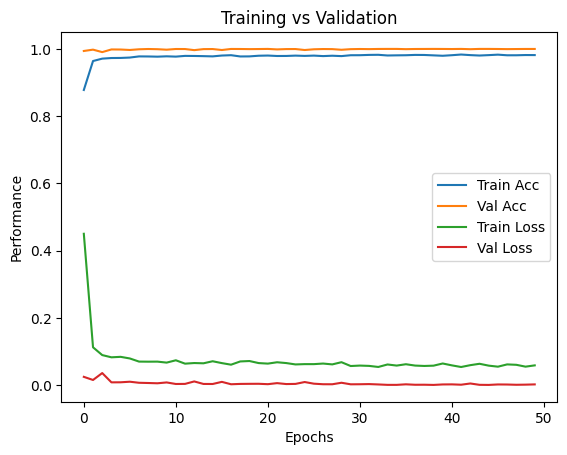

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.title('Training vs Validation')
plt.show()


In [1]:
# Step 3: Enhanced Real-Time Detection (real_time_prediction.py)
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf

# Initialize model and label encoder
model = tf.keras.models.load_model("isl_model.h5")
le = LabelEncoder()
le.classes_ = np.load("classes.npy")

# MediaPipe setup with 2 hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils 
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=2,
                       min_detection_confidence=0.7,
                       min_tracking_confidence=0.5)

def process_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)
    
    landmarks = []
    if results.multi_hand_landmarks:
        # Draw all detected hands
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        
        # Extract landmarks for up to 2 hands
        for hand_landmarks in results.multi_hand_landmarks[:2]:
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
        
        # Pad with zeros if only one hand detected
        if len(results.multi_hand_landmarks) == 1:
            landmarks += [0.0] * 63
        
        # Make prediction
        if len(landmarks) == 126:
            prediction = model.predict(np.array([landmarks]), verbose=0)
            pred_class = le.inverse_transform([np.argmax(prediction)])
            confidence = np.max(prediction)
            return pred_class[0], confidence
    return None, 0

# Main loop
cap = cv2.VideoCapture(0)
while cap.isOpened():
    success, frame = cap.read()
    if not success:
        continue
    
    # Flip frame horizontally for mirror view
    frame = cv2.flip(frame, 1)
    
    class_name, confidence = process_frame(frame)
    
    # Display results
    if class_name:
        cv2.putText(frame, f"{class_name} ({confidence:.2f})",
                    (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    cv2.imshow('Sign Language Recognition', frame)
    
    if cv2.waitKey(5) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

NameError: name 'LabelEncoder' is not defined

In [ ]:
# import cv2
# import numpy as np
# import mediapipe as mp
# import tensorflow as tf
# from sklearn.preprocessing import LabelEncoder

# # Load model and label encoder
# model = tf.keras.models.load_model("isl_model.h5")
# le = LabelEncoder()
# le.classes_ = np.load("classes.npy")

# # Initialize MediaPipe
# mp_hands = mp.solutions.hands
# hands = mp_hands.Hands(static_image_mode=False,
#                        max_num_hands=2,
#                        min_detection_confidence=0.5,
#                        min_tracking_confidence=0.5)
# mp_drawing = mp.solutions.drawing_utils

# # Initialize webcam
# cap = cv2.VideoCapture(0)

# while cap.isOpened():
#     success, frame = cap.read()
#     if not success:
#         continue

#     # Convert to RGB and process
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     results = hands.process(frame_rgb)
    
#     if results.multi_hand_landmarks:
#         for hand_landmarks in results.multi_hand_landmarks:
#             # Extract landmarks
#             landmarks = []
#             for lm in hand_landmarks.landmark:
#                 landmarks.extend([lm.x, lm.y, lm.z])
            
#             # Predict
#             # prediction = model.predict([landmarks])
#             prediction = model.predict(np.array([landmarks]))
#             pred_class = le.inverse_transform([np.argmax(prediction)])
#             confidence = np.max(prediction)
            
#             # Draw results
#             mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
#             cv2.putText(frame, f"{pred_class[0]} ({confidence:.2f})",
#                         (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

#     cv2.imshow('Sign Language Recognition', frame)
    
#     if cv2.waitKey(5) & 0xFF == 27:  # ESC key
#         break

# cap.release()
# cv2.destroyAllWindows()